In [1]:
import sys
sys.path.append("../Utils")   # adjust if models.py is in another folder

from models import DGCNN, PointNet
import configs
import os
import random
from pathlib import Path
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import open3d as o3d
import chardet

# =========================
# Training Hyperparameters
# =========================
num_points = 1024
batch_size = 16
epochs = 20
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
k = 20
emb_dims = 1024
dropout = 0.5

# =========================
# Directories & Classes
# =========================
train_dir = configs.TRAIN_DIR
test_dir = configs.TEST_DIR
model_dir = configs.MODEL_DIR
num_classes = len(list(train_dir.iterdir()))

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print(f"Using device: {device}, Num classes: {num_classes}")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using device: cpu, Num classes: 7


In [2]:
def read_point_file(path):
    """Read .txt/.xyz/.pts files robustly."""
    with open(path, "rb") as f:
        raw = f.read()
        enc = chardet.detect(raw)["encoding"] or "latin1"
        text = raw.decode(enc, errors="ignore")

    data = []
    for line in text.strip().splitlines():
        parts = line.strip().split()
        if len(parts) < 3:
            continue
        try:
            x, y, z = map(float, parts[:3])
            if len(parts) >= 6:
                r, g, b = map(float, parts[3:6])
                data.append([x, y, z, r / 255.0, g / 255.0, b / 255.0])
            else:
                data.append([x, y, z])
        except ValueError:
            continue
    return np.array(data, dtype=np.float32)


def farthest_point_sampling(points, n_samples=1024):
    """
    Farthest Point Sampling using Open3D.
    Ensures exactly n_samples points (pads if needed).
    """
    xyz = points[:, :3]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    pcd = pcd.farthest_point_down_sample(min(len(xyz), n_samples))
    sampled = np.asarray(pcd.points, dtype=np.float32)

    # Pad if too few points
    if sampled.shape[0] < n_samples:
        pad_size = n_samples - sampled.shape[0]
        pad = np.repeat(sampled[:1], pad_size, axis=0)
        sampled = np.vstack([sampled, pad])

    return sampled


In [3]:
class PointCloudDataset(Dataset):
    def __init__(self, root_dir, num_points=1024):
        self.paths = list(Path(root_dir).rglob("*.*"))
        self.labels = [p.parent.name for p in self.paths]
        self.label2idx = {l: i for i, l in enumerate(sorted(set(self.labels)))}
        self.num_points = num_points

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        points = read_point_file(path)
        points = farthest_point_sampling(points, self.num_points)
        points = points[:, :3]   # XYZ only
        label = self.label2idx[self.labels[idx]]
        return torch.tensor(points, dtype=torch.float32), label


In [ ]:
from torch.utils.data import DataLoader, random_split

# Load full train dataset
train_dataset = PointCloudDataset(train_dir, num_points)
test_dataset = PointCloudDataset(test_dir, num_points)

# ---- Split into train & validation ----
val_split = 0.2  # 20% of training data for validation
val_size = int(len(train_dataset) * val_split)
train_size = len(train_dataset) - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# ---- Create DataLoaders ----
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# ---- Quick sanity check ----
for pts, lbl in train_loader:
    print(f"Train batch - points: {pts.shape}, labels: {lbl.shape}")
    break

for pts, lbl in val_loader:
    print(f"Val batch   - points: {pts.shape}, labels: {lbl.shape}")
    break



Batch points shape: torch.Size([16, 1024, 3])


In [ ]:
import time
import torch

def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs):
    """
    Train a model with validation at the end of each epoch.

    Args:
        model: PyTorch model to train.
        train_loader: DataLoader for training set.
        val_loader: DataLoader for validation set.
        optimizer: Optimizer (e.g., Adam, SGD).
        criterion: Loss function.
        device: 'cuda' or 'cpu'.
        epochs: Number of epochs.

    Returns:
        history: Dictionary with train/val loss and accuracy per epoch + batch losses.
    """
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "batch_losses": []
    }

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        start_time = time.time()

        for points, labels in train_loader:
            points, labels = points.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(points)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            history["batch_losses"].append(loss.item())
            total_loss += loss.item() * points.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = total_loss / total
        epoch_acc = correct / total
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        # ===== Validation step =====
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for points, labels in val_loader:
                points, labels = points.to(device), labels.to(device)
                outputs = model(points)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * points.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_correct / val_total
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_epoch_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"| Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} "
              f"| Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} "
              f"| Time: {time.time()-start_time:.1f}s")

    return history



In [7]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for points, labels in loader:
            points, labels = points.to(device), labels.to(device)
            outputs = model(points)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return {
        "overall_acc": accuracy_score(all_labels, all_preds),
        "balanced_acc": balanced_accuracy_score(all_labels, all_preds),
        "f1": f1_score(all_labels, all_preds, average="weighted"),
        "precision": precision_score(all_labels, all_preds, average=None),
        "confusion_matrix": confusion_matrix(all_labels, all_preds),
        "preds": all_preds,
        "labels": all_labels,
    }


In [ ]:


def plot_training_curves(history):
    """
    Plots training & validation loss and accuracy curves.

    Args:
        history: Dictionary returned by train_model(), containing
                 'train_loss', 'val_loss', 'train_acc', 'val_acc'.
    """
    plt.figure(figsize=(12, 5))

    # ---- Loss ----
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    if "val_loss" in history:
        plt.plot(history["val_loss"], label="Val Loss", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # ---- Accuracy ----
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Accuracy")
    if "val_acc" in history:
        plt.plot(history["val_acc"], label="Val Accuracy", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curves")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix with class labels.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names, yticklabels=class_names,
                cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


Model Parameters: 1801095
Epoch [1/20] | Loss: 1.4651 | Acc: 0.4650 | Time: 2503.8s
Epoch [2/20] | Loss: 1.1181 | Acc: 0.5978 | Time: 2433.6s
Epoch [3/20] | Loss: 0.9564 | Acc: 0.6679 | Time: 2240.4s
Epoch [4/20] | Loss: 0.9232 | Acc: 0.6715 | Time: 2122.3s
Epoch [5/20] | Loss: 0.8689 | Acc: 0.7056 | Time: 2384.3s
Epoch [6/20] | Loss: 0.9114 | Acc: 0.6661 | Time: 3314.8s
Epoch [7/20] | Loss: 0.8396 | Acc: 0.6984 | Time: 1981.3s
Epoch [8/20] | Loss: 0.8246 | Acc: 0.7199 | Time: 1982.8s
Epoch [9/20] | Loss: 0.7951 | Acc: 0.7181 | Time: 2195.3s
Epoch [10/20] | Loss: 0.7880 | Acc: 0.7145 | Time: 2552.5s
Epoch [11/20] | Loss: 0.7973 | Acc: 0.7092 | Time: 2029.4s
Epoch [12/20] | Loss: 0.7711 | Acc: 0.7594 | Time: 2162.6s
Epoch [13/20] | Loss: 0.7816 | Acc: 0.7415 | Time: 6569.9s
Epoch [14/20] | Loss: 0.5871 | Acc: 0.7971 | Time: 3054.7s
Epoch [15/20] | Loss: 0.6140 | Acc: 0.8007 | Time: 2055.8s
Epoch [16/20] | Loss: 0.6174 | Acc: 0.7810 | Time: 2678.1s
Epoch [17/20] | Loss: 0.6347 | Acc: 0.7

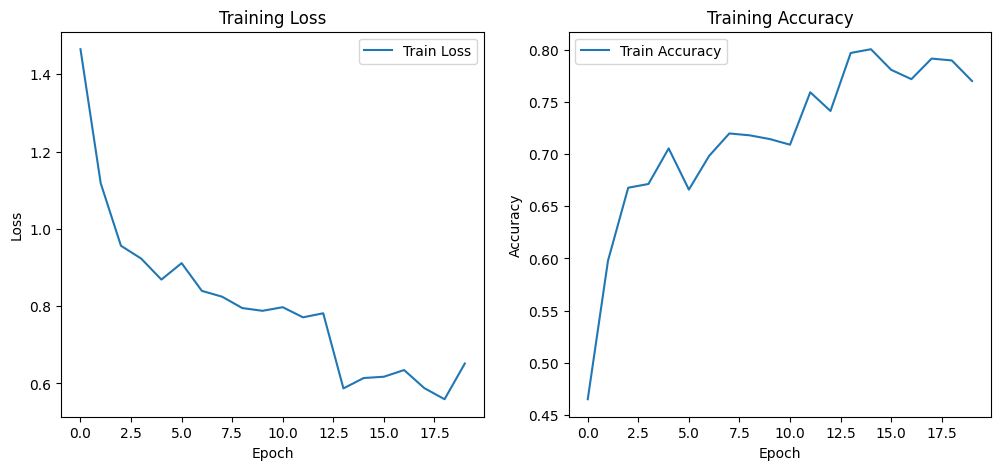

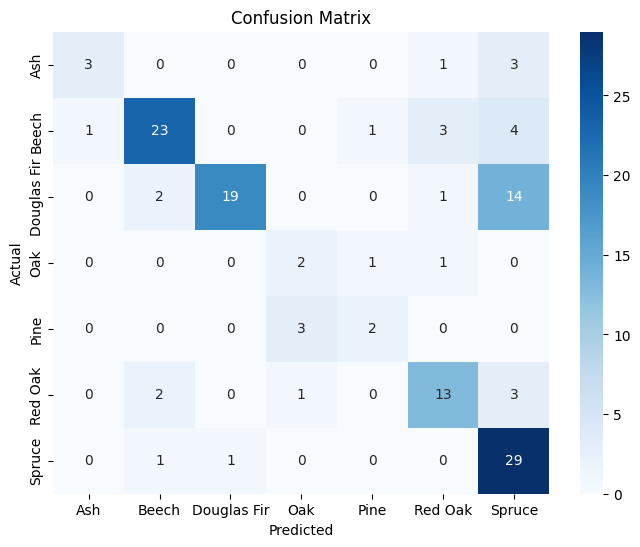

In [ ]:
# Choose model
model = DGCNN(num_classes=num_classes, k=k, emb_dims=emb_dims, dropout=dropout).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Model Parameters: {total_params}")

# ===== Train =====
history = train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs)

# ===== Evaluate on Test Set =====
results = evaluate_model(model, test_loader, device)

print("\n=== Test Results ===")
print(f"Overall Accuracy:  {results['overall_acc']:.4f}")
print(f"Balanced Accuracy: {results['balanced_acc']:.4f}")
print(f"F1 Score:          {results['f1']:.4f}")
print(f"Precision per Class: {results['precision']}")
print(f"Confusion Matrix:\n{results['confusion_matrix']}")

# ===== Visualize =====
plot_training_curves(history)
plot_confusion_matrix(results["confusion_matrix"], class_names=sorted(os.listdir(train_dir)))

PointNet Parameters: 679239
Epoch [1/20] | Loss: 1.5965 | Acc: 0.3680 | Time: 2748.5s
Epoch [2/20] | Loss: 1.3451 | Acc: 0.4811 | Time: 3652.0s
Epoch [3/20] | Loss: 1.3356 | Acc: 0.4596 | Time: 1879.8s
Epoch [4/20] | Loss: 1.3374 | Acc: 0.4524 | Time: 2729.2s
Epoch [5/20] | Loss: 1.3196 | Acc: 0.4955 | Time: 2277.8s
Epoch [6/20] | Loss: 1.3115 | Acc: 0.4937 | Time: 1806.2s
Epoch [7/20] | Loss: 1.3194 | Acc: 0.4722 | Time: 3384.4s
Epoch [8/20] | Loss: 1.2473 | Acc: 0.5027 | Time: 2399.1s
Epoch [9/20] | Loss: 1.2274 | Acc: 0.5117 | Time: 1819.7s
Epoch [10/20] | Loss: 1.2207 | Acc: 0.5242 | Time: 2379.7s
Epoch [11/20] | Loss: 1.2492 | Acc: 0.4973 | Time: 2255.8s
Epoch [12/20] | Loss: 1.2533 | Acc: 0.5314 | Time: 3812.1s
Epoch [13/20] | Loss: 1.2788 | Acc: 0.5117 | Time: 2548.3s
Epoch [14/20] | Loss: 1.2167 | Acc: 0.5224 | Time: 4672.1s
Epoch [15/20] | Loss: 1.1811 | Acc: 0.5189 | Time: 9000.9s
Epoch [16/20] | Loss: 1.1944 | Acc: 0.5224 | Time: 3621.0s
Epoch [17/20] | Loss: 1.2051 | Acc: 0

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Overall Accuracy: 0.5149
Balanced Accuracy: 0.4216
F1 Score: 0.5137
Precision per Class: [0.66666667 0.64705882 0.76       0.         0.14285714 0.39393939
 0.52380952]
Confusion Matrix:
[[ 2  0  2  0  1  1  1]
 [ 1 11  2  0  1  9  8]
 [ 0  6 19  0  3  3  5]
 [ 0  0  0  0  2  0  2]
 [ 0  0  0  0  2  1  2]
 [ 0  0  1  0  3 13  2]
 [ 0  0  1  0  2  6 22]]


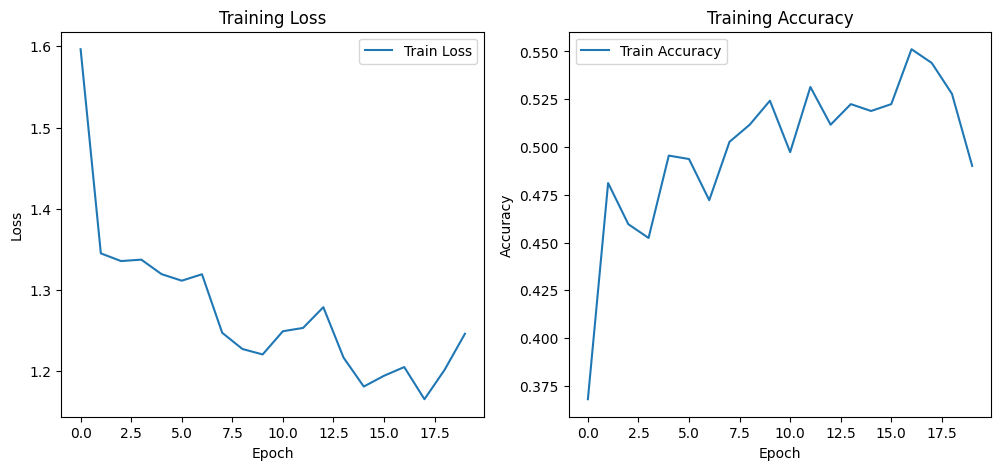

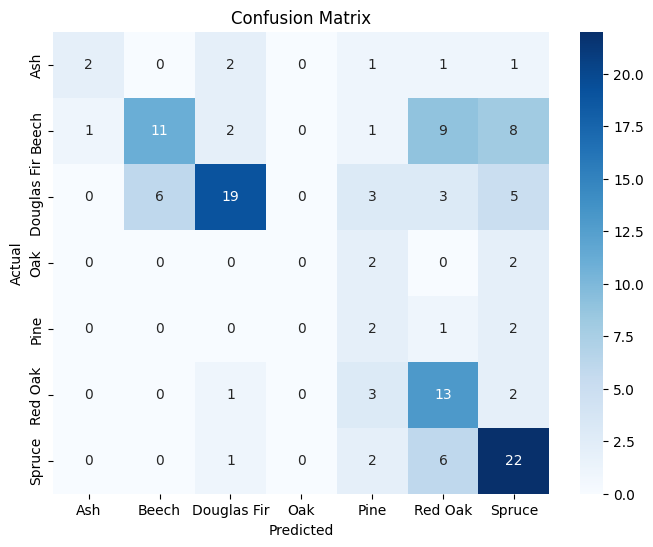

In [10]:
# =========================
# Train & Evaluate PointNet
# =========================

# Instantiate PointNet
model = PointNet(num_classes=num_classes, emb_dims=emb_dims, dropout=dropout).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"PointNet Parameters: {total_params}")

# Train
history = train_model(model, train_loader, optimizer, criterion, device, epochs)

# Evaluate
results = evaluate_model(model, test_loader, device)
print(f"Overall Accuracy: {results['overall_acc']:.4f}")
print(f"Balanced Accuracy: {results['balanced_acc']:.4f}")
print(f"F1 Score: {results['f1']:.4f}")
print(f"Precision per Class: {results['precision']}")
print(f"Confusion Matrix:\n{results['confusion_matrix']}")

# Visualize
plot_training_curves(history)
plot_confusion_matrix(results["confusion_matrix"], class_names=sorted(os.listdir(train_dir)))
